In [1]:
# import ROOT as r
import coffea
import coffea.hist as hist
from coffea.nanoevents.methods import vector
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

# from pyjet import cluster
import awkward as ak

from sklearn.cluster import DBSCAN
import numba
import pickle

In [2]:
import sys
sys.path.insert(0,"../")
import cluster

In [3]:
from coffea import hist, processor
import awkward as ak
import numba

# register our candidate behaviors
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, BaseSchema
ak.behavior.update(candidate.behavior)

@numba.jit
def dR(x,y):
    dphi=(x[1]-y[1] +np.pi) %(2*np.pi)-np.pi
    deta=(x[0]-y[0])    
    return (dphi**2+deta**2)**0.5

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "cluster": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("llp_matched",'dR_llp_matched',2,0,2),                
                hist.Bin("eta", "eta", 20, -3, 3),      
                hist.Bin("time",'time',40, -80, 80),                                 
                hist.Bin("size", "Cluster size", 40, 0, 1000),                
            ),
            "rate": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("cuts", "cuts", 11, 0, 11),   
                hist.Bin("nRechits", "nRechits", 40, 0, 1000),                                 
            ),
            
            "cluster_eta": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("eta",'eta',20,-3,3),                                
            ),            
            "cluster_phi": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("phi",'phi',40,-np.pi,np.pi),                   
            ),                        
            "cluster_eta_sd": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("llp_matched",'dR_llp_matched',2,0,2),                                
                hist.Bin("eta_sd", "eta_sd", 20, 0, 1),                
            ),
            "cluster_phi_sd": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("llp_matched",'dR_llp_matched',2,0,2),                                
                hist.Bin("phi_sd", "phi_sd", 20, 0, 1),
            ),
            "cluster_width": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("llp_matched",'dR_llp_matched',2,0,2),                                
                hist.Bin("width", "R(eta_sd,phi_sd)", 20, 0, 1),
            ),        

            "cluster_prop": hist.Hist("Events",
                hist.Cat("algo", "algo"),
                hist.Bin("eta", "eta", 20, -3, 3),                                      
                hist.Bin("time",'time',40, -80, 80),                                       
                hist.Bin("nStation10", "nStation10", 5, 0, 5),                
                hist.Bin("avgStation10", "avgStation10", 40, 0, 10),
            ),                    
            "nCluster": hist.Hist("Events",hist.Cat("algo", "algo"),
                hist.Bin("nClusters", "nCluster", 10, 0, 10),                
            ),
#              "delta_cls": hist.Hist("Events",
#                 hist.Bin("dR", "dR(CA_cls,db_cls)", 20, 0, 1),
#             ),
             "deltaR_llp": hist.Hist("Events",
                hist.Cat("algo", "algo"),
                hist.Bin("dR", "dR(cls,llp)", 20, 0, 1),                 
            ),

                        
        })

    @property
    def accumulator(self):
        return self._accumulator


    def performClusters(self,algo,X):
        if "CA" in algo['name']:
            clusters = cluster.CAcluster(X,dR=algo['pams']['dR'],nCore=algo['pams']['nCore'])
        elif "DB" in algo['name']:
            clusters = cluster.DBScan(X,nCore=algo['pams']['nCore'],eps=algo['pams']['eps'])        
        return clusters

    
    def process(self, events):
        output = self.accumulator.identity()
        output['sumw']

        dataset = events.metadata['dataset']
        
        start,stop = events._branchargs['entry_start'],events._branchargs['entry_stop']
        events = uproot.lazy(events._tree)
        events = events[start:stop]
        output['sumw'][dataset]+=len(events)        
        
        if "zerobias" in dataset:
            isSignal =False
        else:
            isSignal= ak.any(events.gLLP_csc)        
        if isSignal:        
            csc = ak.any(events.gLLP_csc,axis=1)
            events = events[(csc==1)]        
        
        nRechits = events.ncscRechits

        rechits = ak.zip({
            "eta":events.cscRechitsEta,
            "phi":events.cscRechitsPhi,
            'x':events.cscRechitsX,
            'y':events.cscRechitsY,    
            'z':events.cscRechitsZ, 
            't':events.cscRechitsTpeak,
            'twire':events.cscRechitsTwire,
            'station':events.cscRechitsStation,
            'chamber':events.cscRechitsChamber,
        })
        
        DTrechits = ak.zip({
            "eta":events.dtRechitEta,
            "phi":events.dtRechitPhi,
            'x':events.dtRechitX,
            'y':events.dtRechitY,
            'z':events.dtRechitZ,
            't':events.dtRechitTime,
            'twire':ak.zeros_like(events.dtRechitX),
            'station':events.dtRechitStation,
            'chamber':ak.zeros_like(events.dtRechitX),
        })
        algos = [
            {"name":"CA(dR=0.2,nCore>50)"     ,"pams":{"dR":0.2,'nCore':50},'dR_cut':0.2},
            {"name":"CA(dR=0.3,nCore>50)"     ,"pams":{"dR":0.3,'nCore':50},'dR_cut':0.3},            
#             {"name":"CA(dR=0.4,nCore>50)"     ,"pams":{"dR":0.4,'nCore':50},'dR_cut':0.4},                        
            {"name":"DBScan(eps=0.2,nCore=50)","pams":{"eps":0.2,"nCore":50},'dR_cut':0.2},
        ]

        
        for algo in algos:
            dR_cut = algo['dR_cut']            
#             clusters = self.performClusters(algo,rechits) 
            clusters = self.performClusters(algo,DTrechits)             
            
#             if not isSignal:
#                 clusters = clusters[(clusters.time<25) & (clusters.time>-25)]   #select OOT for data
            
            cls_nCS=ak.num(clusters,axis=1).size;
            cls_eta=clusters.eta;      cls_phi=clusters.phi
            cls_eta_sd=clusters.eta_sd; cls_phi_sd=clusters.phi_sd            
            cls_size=clusters.size;    cls_width=clusters.width
            cls_n_ME11_12 = clusters.n_ME11_12;
            
            baseline = (abs(clusters.eta)<1.9) & (abs(clusters.time)<25) & (clusters.n_ME11_12==0)
            cuts = [
                cls_nCS>0,
                ak.any(abs(clusters.time)<25,axis=1),               
                ak.any(abs(clusters.eta)<1.9,axis=1),
                ak.any(clusters.n_ME11_12==0,axis=1),
                ak.any(baseline & (clusters.size>100),axis=1),
                ak.any(baseline & (clusters.size>150),axis=1),                
                ak.any(baseline & (clusters.size>175),axis=1),
                ak.any(baseline & (clusters.size>200),axis=1),                
                ak.any(baseline & (clusters.size>225),axis=1),
                ak.any(baseline & (clusters.size>275),axis=1),                
            ]
            allcuts = cuts[0]
            output['rate'].fill(algo=algo['name'],cuts=0,nRechits=events.ncscRechits)
            for i,cut in enumerate(cuts):
                allcuts = (allcuts & cut)
                output['rate'].fill(algo=algo['name'],cuts=i+1,
                                   nRechits=events[allcuts].ncscRechits)
                                
            output['nCluster'].fill(algo=algo['name'],nClusters=cls_nCS)         
            
            cls=ak.zip({
                'pt':ak.ones_like(cls_phi),
                'eta':cls_eta,
                'phi':cls_phi,
                'mass':ak.zeros_like(cls_phi)
            },with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior    
            )                
            if isSignal:
                llp_cls = ak.cartesian({"cls": cls,"llp":llp}, nested=True, axis=1)                
                dR_llp_cls = llp_cls.cls.delta_r(llp_cls.llp)
                dR_matched_llp_cls= ak.values_astype(ak.any(dR_llp_cls<dR_cut,axis=2),np.int)     
            else:
                dR_matched_llp_cls=ak.zeros_like(cls_phi)
                dR_llp_cls=ak.ones_like(cls_phi)*-1         
                
                
            output['deltaR_llp'].fill(algo=algo['name'],
                                      dR=ak.flatten(dR_llp_cls,axis=None))      
#             output['cluster_spread'].fill(algo=algo['name'],
#                                llp_matched = ak.flatten(dR_matched_llp_cls,axis=None),                                                                     
#                                eta_sd=ak.flatten(cls_eta_sd),
#                                phi_sd=ak.flatten(cls_phi_sd),                               
#                                width=ak.flatten(cls_width))        
            output['cluster'].fill(algo=algo['name'],
                               llp_matched = ak.flatten(dR_matched_llp_cls,axis=None),
                               eta=ak.flatten(cls_eta),
                               size=ak.flatten(cls_size),
                               time=ak.flatten(clusters.time),
                                  )     
            output['cluster_prop'].fill(algo=algo['name'],   
                               eta=ak.flatten(cls_eta),
                               time=ak.flatten(clusters.time),
                               nStation10=ak.flatten(clusters.nStation10),                               
                               avgStation10=ak.flatten(clusters.avgStation10))                    

        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [13]:
fileset = {
#     'Higgs': [
#         '/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/displacedJetMuon_ntupler_95.root',
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_1.root",
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_2.root",        
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_3.root" ,       
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_4.root" ,       
#     ],
#     r'HNL,$m_N$=5': [
#         '/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/HNL/HeavyNeutralLepton_Tree.root',
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/HNL_testpoint1/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v2_v1_v4/201113_200701/0000/displacedJetMuon_ntupler_100.root",
# "root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/HNL_testpoint1/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v2_v1_v4/201113_200701/0000/displacedJetMuon_ntupler_101.root"        
#     ],
#     'data':[
#         'root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/Data2018/v5/sixie/MET/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018A-HighMET-17Sep2018-v1_v5_v1/200513_161806/0000/displacedJetMuon_ntupler_104.root',
#         'root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/Data2018/v5/sixie/MET/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018A-HighMET-17Sep2018-v1_v5_v1/200513_161806/0000/displacedJetMuon_ntupler_105.root',
#         'root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/Data2018/v5/sixie/MET/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018A-HighMET-17Sep2018-v1_v5_v1/200513_161806/0000/displacedJetMuon_ntupler_106.root',        
#         'root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/Data2018/v5/sixie/MET/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018A-HighMET-17Sep2018-v1_v5_v1/200513_161806/0000/displacedJetMuon_ntupler_107.root',  
        
#     ]
    'zerobias18':[ "~/eos/llp/zerobias18/displacedJetMuon_ntupler.root"]
}

out = processor.run_uproot_job(
    fileset,
    treename="ntuples/llp",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": None,
    },
    maxchunks=1,
    chunksize=10
)
out

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

{'sumw': defaultdict_accumulator(float, {'zerobias18': 10.0}),
 'cluster': <Hist (algo,llp_matched,eta,time,size) instance at 0x7f5ff15fce50>,
 'rate': <Hist (algo,cuts,nRechits) instance at 0x7f5fe87a5690>,
 'cluster_eta': <Hist (algo,eta) instance at 0x7f5fe891e2d0>,
 'cluster_phi': <Hist (algo,phi) instance at 0x7f5fe891e8d0>,
 'cluster_eta_sd': <Hist (algo,llp_matched,eta_sd) instance at 0x7f5ff1bdf610>,
 'cluster_phi_sd': <Hist (algo,llp_matched,phi_sd) instance at 0x7f5ff1bdf650>,
 'cluster_width': <Hist (algo,llp_matched,width) instance at 0x7f5ff1bdf690>,
 'cluster_prop': <Hist (algo,eta,time,nStation10,avgStation10) instance at 0x7f5ff1bdf6d0>,
 'nCluster': <Hist (algo,nClusters) instance at 0x7f5ff1bdf710>,
 'deltaR_llp': <Hist (algo,dR) instance at 0x7f5ff1bdf790>}

In [14]:
with open('clustering_histograms.pickle','wb') as f:
    pickle.dump(out,f)

In [3]:
# with open('clustering_histograms_higgsTo4b.pickle','rb') as f:
# with open('clustering_histograms_data.pickle','rb') as f:
# with open('clustering_histograms_data_intime.pickle','rb') as f:
# with open('clustering_histograms_data_cuts.pickle','rb') as f:
# with open('../clustering_histograms_tcut_may27.pickle','rb') as f:    
# with open('../clustering_histograms_postCut_Jun2.pickle','rb') as f:    
# with open('../clustering_histograms_incl_Jun8.pickle','rb') as f:    
with open('../clustering_histograms_incl_Jun10.pickle','rb') as f:        
    out = pickle.load(f)

In [4]:
out

{'sumw': defaultdict_accumulator(float, {'zerobias18': 2546.0}),
 'cluster': <Hist (algo,llp_matched,eta,time,size) instance at 0x7fe7ec32fe10>,
 'rate': <Hist (algo,cuts,nRechits) instance at 0x7fe7ebc29510>,
 'cluster_eta': <Hist (algo,eta) instance at 0x7fe7ebc29c10>,
 'cluster_phi': <Hist (algo,phi) instance at 0x7fe86d038a10>,
 'cluster_eta_sd': <Hist (algo,eta_sd) instance at 0x7fe7ebc2f590>,
 'cluster_phi_sd': <Hist (algo,phi_sd) instance at 0x7fe7ebc2fc50>,
 'cluster_width': <Hist (algo,width) instance at 0x7fe7ebc34350>,
 'cluster_time': <Hist (algo,nCls,time) instance at 0x7fe7ebc34a10>,
 'cluster_time_sd': <Hist (algo,time_sd) instance at 0x7fe7ebc39350>,
 'cluster_nStation10': <Hist (algo,nStation10) instance at 0x7fe7ebc399d0>,
 'cluster_avgStation10': <Hist (algo,avgStation10) instance at 0x7fe7ebc3e090>,
 'cluster_n_ME11_12': <Hist (algo,n_ME11_12) instance at 0x7fe7ebc3e710>,
 'cluster_prop': <Hist (algo,eta,phi,time) instance at 0x7fe7ebc3edd0>,
 'nCluster': <Hist (alg

CA(dR=0.2,nCore>50) [530.   321.91  70.34  48.09  22.05   9.87   4.41   2.52   2.1    1.47
   0.84]
CA(dR=0.3,nCore>50) [530.   328.    70.76  48.3   21.     9.66   4.62   2.94   2.31   1.47
   0.84]
CA(dR=0.4,nCore>50) [530.   331.56  71.18  47.67  19.53   9.87   5.04   3.15   2.31   1.47
   1.05]
DBScan(eps=0.2,nCore=50) [530.   326.32  69.5   47.04  19.95  10.08   4.83   3.15   2.31   1.47
   0.84]


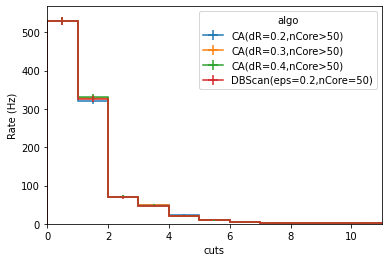

In [6]:
h = out['rate'].project('algo','cuts')
h.label="Rate (Hz)"
Fullrate = 530
norm = {}
for d,cutflow in h.values().items():
    norm[d[0]]=(1./cutflow[0])*Fullrate
#     print(d[0],cutflow)
    print(d[0],np.round(cutflow/cutflow[0]*Fullrate,2))
h.scale(norm , "algo")   
ax = hist.plot1d(h,overlay='algo')
# ax.set_yscale('log')
# ax.set_ylim(1e-1,None)

<AxesSubplot:xlabel='cuts', ylabel='Events'>

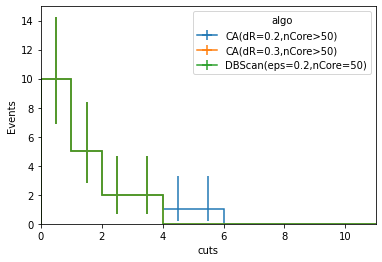

In [21]:
hist.plot1d(out["rate"].project('algo',"cuts"),overlay="algo")

<AxesSubplot:xlabel='phi1', ylabel='phi2'>

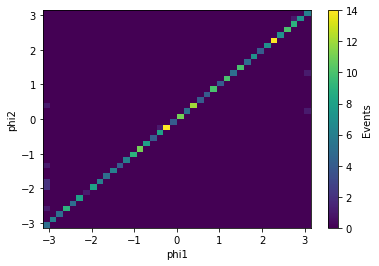

In [12]:
hist.plot2d(out['cluster_phi'].project("phi1",'phi2'),xaxis='phi1')

<AxesSubplot:xlabel='eta1', ylabel='eta2'>

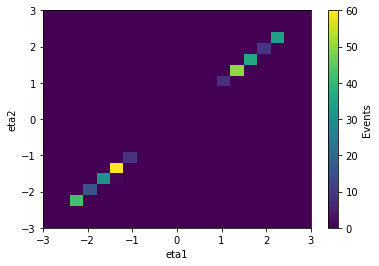

In [13]:
hist.plot2d(out['cluster_eta'].project("eta1",'eta2'),xaxis='eta1')

In [7]:
out['cluster']

<Hist (algo,llp_matched,eta,time,size) instance at 0x7fdfe21a2c10>

<AxesSubplot:xlabel='time', ylabel='Events'>

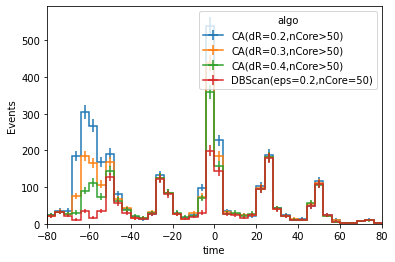

In [5]:
hist.plot1d(out['cluster'].project("time",'algo'),overlay='algo')

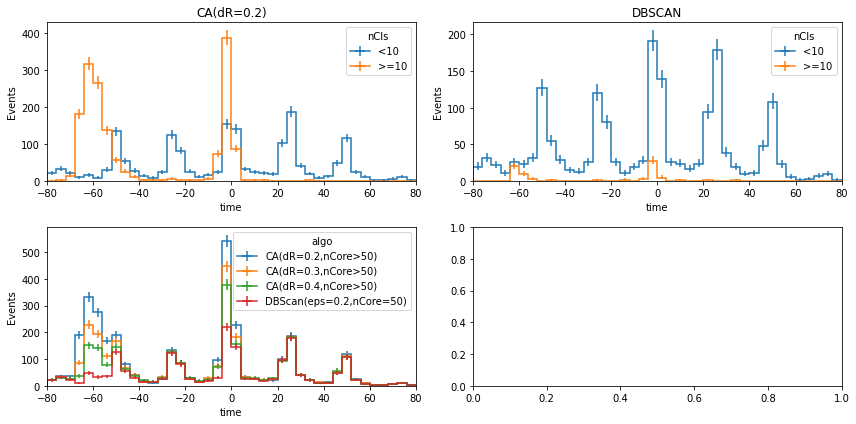

In [7]:
h= out['cluster_time']

fig, axs = plt.subplots(2,2,figsize=(12,6))
axs = axs.flatten()
hist.plot1d(h[0:1].project('nCls','time'),ax=axs[0],overlay='nCls')
hist.plot1d(h[3:4].project('nCls','time'),ax=axs[1],overlay='nCls')
axs[0].set_title("CA(dR=0.2)")
axs[1].set_title("DBSCAN")
hist.plot1d(h.project('algo','time'),ax=axs[2],overlay='algo')
plt.tight_layout()

<AxesSubplot:xlabel='time', ylabel='eta'>

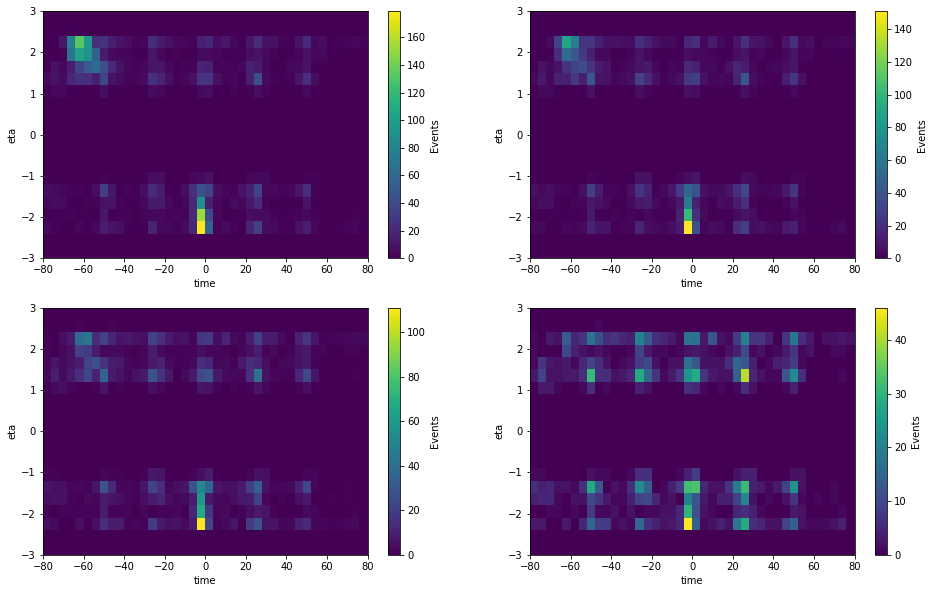

In [9]:
fig, axs = plt.subplots(2,2,figsize=(16,10))

axs = axs.flatten()

hist.plot2d(out['cluster'][0:1].project("eta",'time'),ax=axs[0],xaxis='time')
hist.plot2d(out['cluster'][1:2].project("eta",'time'),ax=axs[1],xaxis='time')
hist.plot2d(out['cluster'][2:3].project("eta",'time'),ax=axs[2],xaxis='time')
hist.plot2d(out['cluster'][3:4].project("eta",'time'),ax=axs[3],xaxis='time')

In [16]:
out['cluster_prop']

<Hist (algo,eta,phi,time) instance at 0x7fdfe21cf110>

<AxesSubplot:xlabel='eta', ylabel='phi'>

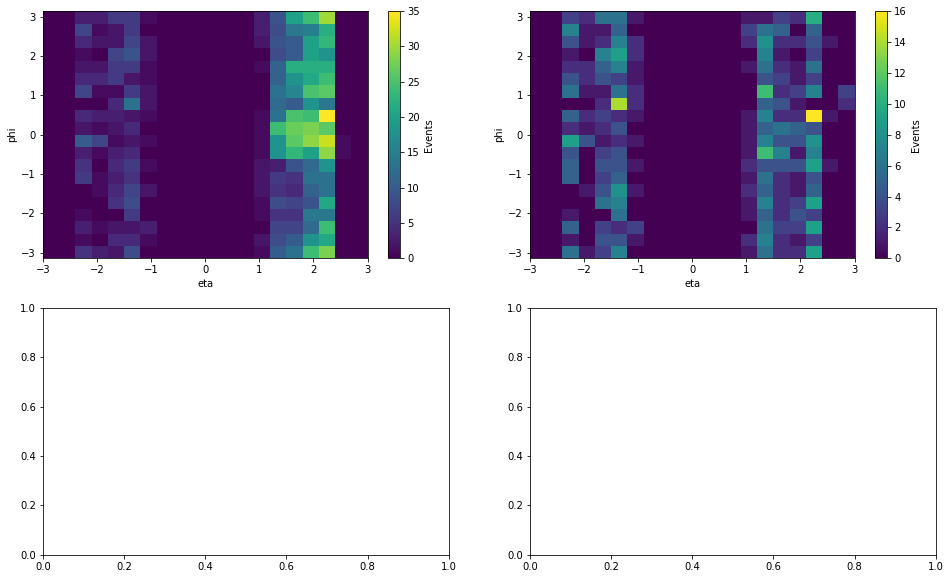

In [26]:
fig, axs = plt.subplots(2,2,figsize=(16,10))


axs = axs.flatten()

hist.plot2d((out['cluster_prop'][0:1]).integrate("time",slice(None,-20)).project("phi",'eta'),ax=axs[0],xaxis='eta')
hist.plot2d((out['cluster_prop'][3:4]).integrate("time",slice(None,-20)).project("phi",'eta'),ax=axs[1],xaxis='eta')
# hist.plot2d(out['cluster_prop'][1:2].project("phi",'time'),ax=axs[1],xaxis='time')
# hist.plot2d(out['cluster_prop'][2:3].project("phi",'time'),ax=axs[2],xaxis='time')
# hist.plot2d(out['cluster_prop'][3:4].project("phi",'time'),ax=axs[3],xaxis='time')

In [10]:
out['nCluster'].sum('nClusters').values(overflow="all")

{('CA(dR=0.2,nCore>50)',): 2524.0,
 ('CA(dR=0.3,nCore>50)',): 2524.0,
 ('CA(dR=0.4,nCore>50)',): 2524.0,
 ('DBScan(eps=0.2,nCore=50)',): 2496.0}

In [38]:
out['cluster_phi'].sum('phi').values()

{('CA(dR=0.2,nCore>50)',): 3289.0,
 ('CA(dR=0.3,nCore>50)',): 2711.0,
 ('CA(dR=0.4,nCore>50)',): 2376.0,
 ('DBScan(eps=0.2,nCore=50)',): 1778.0}

In [43]:
for d,v in out['nCluster'].values(overflow="all").items():
    print(d,np.dot(v,np.arange(len(v-1))),v,np.arange(len(v))-1)
for d,v in out['cluster'].project('algo','size').values().items():
    print(d,np.sum(v))
#     print(np.round(v/np.sum(v),3))

for d,v in out['cluster_eta'].values().items():
    print(d,np.sum(v))

('CA(dR=0.2,nCore>50)',) 1903.0 [   0.  991. 1393.  130.   10.    0.    0.    0.    0.    0.    0.   22.] [-1  0  1  2  3  4  5  6  7  8  9 10]
('CA(dR=0.3,nCore>50)',) 1874.0 [   0.  962. 1473.   86.    3.    0.    0.    0.    0.    0.    0.   22.] [-1  0  1  2  3  4  5  6  7  8  9 10]
('CA(dR=0.4,nCore>50)',) 1884.0 [   0.  945. 1499.   75.    5.    0.    0.    0.    0.    0.    0.   22.] [-1  0  1  2  3  4  5  6  7  8  9 10]
('DBScan(eps=0.2,nCore=50)',) 1771.0 [0.000e+00 9.270e+02 1.495e+03 6.000e+01 2.000e+00 1.000e+00 2.000e+00
 1.000e+00 5.000e+00 2.000e+00 1.000e+00 7.000e+00] [-1  0  1  2  3  4  5  6  7  8  9 10]
('CA(dR=0.2,nCore>50)',) 3239.0
('CA(dR=0.3,nCore>50)',) 2611.0
('CA(dR=0.4,nCore>50)',) 2247.0
('DBScan(eps=0.2,nCore=50)',) 1721.0
('CA(dR=0.2,nCore>50)',) 3289.0
('CA(dR=0.3,nCore>50)',) 2711.0
('CA(dR=0.4,nCore>50)',) 2376.0
('DBScan(eps=0.2,nCore=50)',) 1769.0


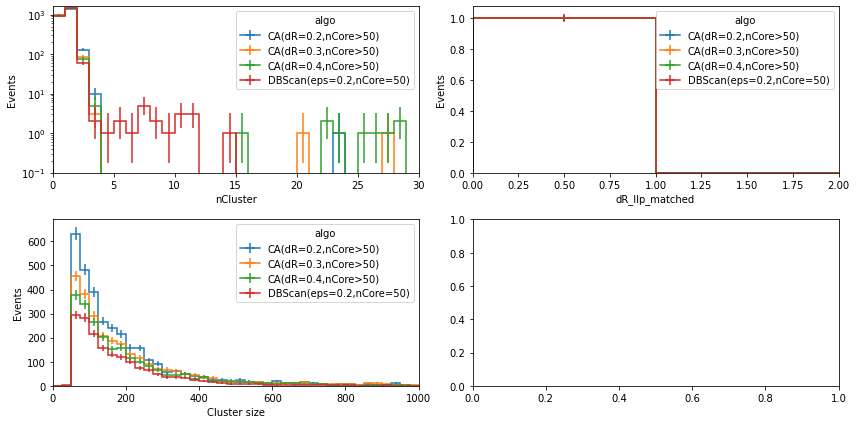

In [13]:
h=out['cluster']
# d=out['delta_cls']
ncols=2
nrows=2
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()


hist.plot1d(out['nCluster'],ax=axs[0]    ,density=False, overlay='algo')

# axs[0].set_ylim(1E-1,None);axs[0].set_yscale('log')
# hist.plot1d(h.project('algo','cls_matched'),ax=axs[1],density=True, overlay='algo')
hist.plot1d(h.project('algo','llp_matched'),ax=axs[1],density=True, overlay='algo')
hist.plot1d(h.project('algo','size'),ax=axs[2],density=False, overlay='algo')
# axs[2].set_ylim(1E-3,1);axs[2].set_yscale('log')
axs[0].set_ylim(1E-1,None);axs[0].set_yscale('log')


plt.tight_layout()
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'rowNum'

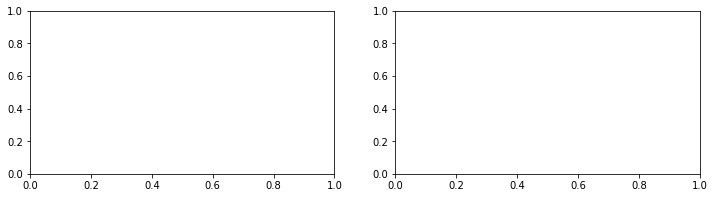

In [154]:
h=out['cluster']
r=out['cluster_spread']

ncols=2
nrows=1
figsize=(6,3)

axs=[]

# h = h.integrate('llp_matched',slice(1,None))

h= h.rebin("size", hist.Bin("size", "Cluster size", 20,0,1000))

for i,a in enumerate(['size','eta','phi']):
    fig, axs = plt.subplots(nrows,ncols,
                            figsize=[ncols*figsize[0],nrows*figsize[1]])
    hist.plotgrid(
        h.project(a,'algo','llp_matched'),
        figure=fig,
        col='llp_matched',
        overlay='algo',
        density=True,
    )
for i,a in enumerate(['eta_sd','phi_sd','width']):
    fig, axs = plt.subplots(nrows,ncols,
                            figsize=[ncols*figsize[0],nrows*figsize[1]])    
    hist.plotgrid(
        r.project(a,'algo','llp_matched'),
        figure=fig,
        col='llp_matched',
        overlay='algo',
        density=True,
    )    
plt.tight_layout()
plt.show()

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)


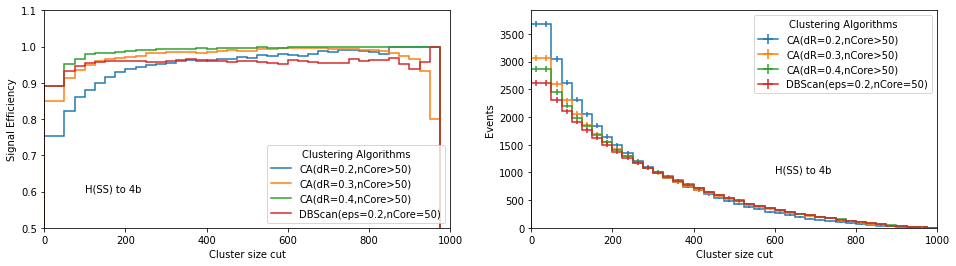

In [11]:
import mplhep

h=out['cluster']
h = h.to_hist()
## turn into cumulative
h[:,:,:,:,:]=np.cumsum(h.view(),axis=4)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs = axs.flatten()
for i,algo in enumerate(h.axes[0]):
    #select the algo    
    tmp = h[i,:,:,:,:] 
    denom = tmp.project('size')
    matched = tmp[1,...].project('size')        # 1 access the matched component
    denom[:] = (denom.view()[-1]-denom.view())  # -1 access the sum of all events
    matched[:] = matched.view()[-1]-matched.view()    
    tmp = matched/denom.view()
    mplhep.histplot(tmp, ax=axs[0],label=algo)
    mplhep.histplot(denom, ax=axs[1],label=algo)    

axs[0].set_xlim(0,1000);axs[0].set_ylim(0.5,1.1)
axs[0].set_xlabel("Cluster size cut");axs[0].set_ylabel("Signal Efficiency")    
axs[0].legend(loc=4,title="Clustering Algorithms")
axs[0].text(100,0.6,"H(SS) to 4b")

axs[1].set_xlim(0,1000);axs[0].set_ylim(0.5,1.1)
axs[1].set_xlabel("Cluster size cut");axs[1].set_ylabel("Events")    
axs[1].legend(loc=1,title="Clustering Algorithms")
axs[1].text(600,1000,"H(SS) to 4b")

plt.show()

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/boost_histogram/_internal/hist.py:369: RuntimeWarning: invalid value encountered in true_divide
  getattr(view, name)(other)


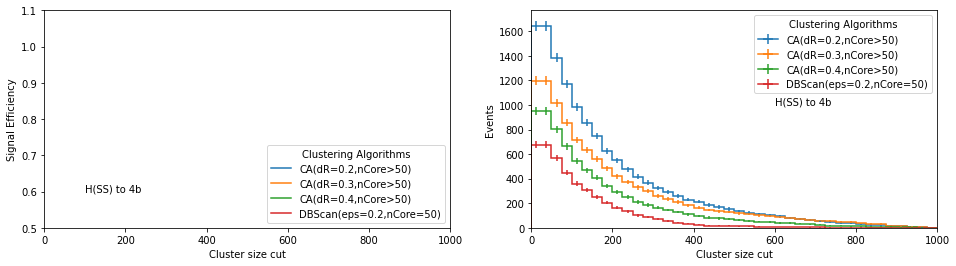

In [10]:
import mplhep

h=out['cluster']
h = h.to_hist()
## turn into cumulative
h[:,:,:,:,:]=np.cumsum(h.view(),axis=4)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs = axs.flatten()
for i,algo in enumerate(h.axes[0]):
    #select the algo    
    tmp = h[i,:,:,:,:] 
    denom = tmp.project('size')
    matched = tmp[1,...].project('size')        # 1 access the matched component
    denom[:] = (denom.view()[-1]-denom.view())  # -1 access the sum of all events
    matched[:] = matched.view()[-1]-matched.view()    
    tmp = matched/denom.view()
    mplhep.histplot(tmp, ax=axs[0],label=algo)
    mplhep.histplot(denom, ax=axs[1],label=algo)    

axs[0].set_xlim(0,1000);axs[0].set_ylim(0.5,1.1)
axs[0].set_xlabel("Cluster size cut");axs[0].set_ylabel("Signal Efficiency")    
axs[0].legend(loc=4,title="Clustering Algorithms")
axs[0].text(100,0.6,"H(SS) to 4b")

axs[1].set_xlim(0,1000);axs[0].set_ylim(0.5,1.1)
axs[1].set_xlabel("Cluster size cut");axs[1].set_ylabel("Events")    
axs[1].legend(loc=1,title="Clustering Algorithms")
axs[1].text(600,1000,"H(SS) to 4b")

plt.show()

In [43]:
# events_raw = uproot.open("../displacedJetMuon_ntupler_84_HNL.root")['ntuples/llp']
events_raw = uproot.open("~/eos/llp/zerobias18/displacedJetMuon_ntupler.root")['ntuples/llp']
df = coffea.processor.LazyDataFrame(events_raw)

start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
events = uproot.lazy(df._tree)
events = events[start:stop]

nRechits = events.ncscRechits
rechits = ak.zip({
    "eta":events.cscRechitsEta,
    "phi":events.cscRechitsPhi,
    'x':events.cscRechitsX,
    'y':events.cscRechitsY,    
    'z':events.cscRechitsZ, 
    't':events.cscRechitsTpeak,
    'twire':events.cscRechitsTwire,
    'station':events.cscRechitsStation,
    'chamber':events.cscRechitsChamber,
})

In [47]:
ak.max(rechits.t)

197.67146